In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json

import os
import random
from random import random, randint, seed
import pickle
import pathlib
import warnings
import platform

import cv2 as cv
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.applications import densenet, MobileNetV3Large, efficientnet, nasnet, MobileNetV2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
print("Python- Versão: ", platform.python_version())
print("TensorFLow - Versão: ",tf.__version__)

# Checar GPUs
if not tf.test.gpu_device_name():
    warnings.warn('GPU não encontrada.')
else:
    print(f'Dispositivo GPU padrão: {tf.test.gpu_device_name()}')
    print("Número de GPUs Disponíveis: ", len(tf.config.list_physical_devices('GPU')))


Python- Versão:  3.8.13
TensorFLow - Versão:  2.10.0
Dispositivo GPU padrão: /device:GPU:0
Número de GPUs Disponíveis:  1


In [3]:
for dirpath, dirnames, filenames in os.walk('BreakHis400x_train_val/Dataset'):
    if len(filenames)!=0:
        print(f'Existem {len(filenames)} imagens em  {dirpath}.')


Existem 1037 imagens em  BreakHis400x_train_val/Dataset\train_set\benign.
Existem 1037 imagens em  BreakHis400x_train_val/Dataset\train_set\malignant.
Existem 180 imagens em  BreakHis400x_train_val/Dataset\validation_set\benign.
Existem 180 imagens em  BreakHis400x_train_val/Dataset\validation_set\malignant.


In [4]:
train_dir = 'BreakHis400x_train_val/Dataset/train_set/'
val_dir = 'BreakHis400x_train_val/Dataset/validation_set/'
test_dir = 'BreCaHAD_test/dataset'

# Especificações para o treinamento da rede
IMG_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
EPOCHS = 100

In [5]:
train_datagen = ImageDataGenerator(rescale=None)
valid_datagen = ImageDataGenerator(rescale=None)
test_datagen = ImageDataGenerator(rescale=None)

train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE,  
                                               target_size=(224, 224), 
                                               class_mode="categorical")

val_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=BATCH_SIZE,  
                                               target_size=(224, 224), 
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=BATCH_SIZE,  
                                               target_size=(224, 224), 
                                               class_mode="categorical")

Found 2074 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Found 159 images belonging to 2 classes.


In [6]:
# Criar a arquitetura da camada densa do modelo para o Fine Tuning
inputs = Input(shape=IMG_SHAPE)

xi = tf.cast(inputs, tf.float32)
xi = tf.keras.applications.nasnet.preprocess_input(xi)

basemodel = nasnet.NASNetMobile(include_top=False,
                                 weights='imagenet',
                                 input_tensor = xi,
                                 input_shape=IMG_SHAPE,
                                 pooling='max')

x = Dense(128, activation="relu")(basemodel.output)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

outputs = Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.cast (TFOpLambda)           (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['tf.cast[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 224, 224, 3)  0           ['tf.math.truediv[0][0]']    

                                                                 eft1_stem_1[0][0]',              
                                                                  'separable_conv_2_bn_reduction_r
                                                                 ight1_stem_1[0][0]']             
                                                                                                  
 separable_conv_1_reduction_rig  (None, 56, 56, 11)  1920        ['separable_conv_1_pad_reduction_
 ht2_stem_1 (SeparableConv2D)                                    right2_stem_1[0][0]']            
                                                                                                  
 separable_conv_1_pad_reduction  (None, 115, 115, 32  0          ['activation_7[0][0]']           
 _right3_stem_1 (ZeroPadding2D)  )                                                                
                                                                                                  
 activatio

                                )                                                                 
                                                                                                  
 reduction_add3_stem_1 (Add)    (None, 56, 56, 11)   0           ['reduction_left3_stem_1[0][0]', 
                                                                  'separable_conv_2_bn_reduction_r
                                                                 ight3_stem_1[0][0]']             
                                                                                                  
 add (Add)                      (None, 56, 56, 11)   0           ['reduction_add_2_stem_1[0][0]', 
                                                                  'reduction_left4_stem_1[0][0]'] 
                                                                                                  
 reduction_add4_stem_1 (Add)    (None, 56, 56, 11)   0           ['separable_conv_2_bn_reduction_l
          

 activation_16 (Activation)     (None, 56, 56, 22)   0           ['adjust_bn_stem_2[0][0]']       
                                                                                                  
 separable_conv_2_bn_reduction_  (None, 28, 28, 22)  88          ['separable_conv_2_reduction_left
 left1_stem_2 (BatchNormalizati                                  1_stem_2[0][0]']                 
 on)                                                                                              
                                                                                                  
 separable_conv_2_bn_reduction_  (None, 28, 28, 22)  88          ['separable_conv_2_reduction_righ
 right1_stem_2 (BatchNormalizat                                  t1_stem_2[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable

 separable_conv_2_bn_reduction_  (None, 28, 28, 22)  88          ['separable_conv_2_reduction_righ
 right3_stem_2 (BatchNormalizat                                  t3_stem_2[0][0]']                
 ion)                                                                                             
                                                                                                  
 reduction_left4_stem_2 (Averag  (None, 28, 28, 22)  0           ['reduction_add_1_stem_2[0][0]'] 
 ePooling2D)                                                                                      
                                                                                                  
 separable_conv_2_bn_reduction_  (None, 28, 28, 22)  88          ['separable_conv_2_reduction_left
 left4_stem_2 (BatchNormalizati                                  4_stem_2[0][0]']                 
 on)                                                                                              
          

 separable_conv_1_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_1_normal_left1_0
 t1_0 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 28, 28, 44)  176         ['separable_conv_1_normal_right1_
 ht1_0 (BatchNormalization)                                      0[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_1_normal_left2_0
 t2_0 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 28, 28, 44)  176         ['separable_conv_1_normal_right2_
 ht2_0 (Ba

                                                                  'normal_right4_0[0][0]']        
                                                                                                  
 normal_add_5_0 (Add)           (None, 28, 28, 44)   0           ['separable_conv_2_bn_normal_left
                                                                 5_0[0][0]',                      
                                                                  'normal_bn_1_0[0][0]']          
                                                                                                  
 normal_concat_0 (Concatenate)  (None, 28, 28, 264)  0           ['adjust_bn_0[0][0]',            
                                                                  'normal_add_1_0[0][0]',         
                                                                  'normal_add_2_0[0][0]',         
                                                                  'normal_add_3_0[0][0]',         
          

 separable_conv_2_normal_left1_  (None, 28, 28, 44)  3036        ['activation_36[0][0]']          
 1 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right1  (None, 28, 28, 44)  2332        ['activation_38[0][0]']          
 _1 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left2_  (None, 28, 28, 44)  3036        ['activation_40[0][0]']          
 1 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right2  (None, 28, 28, 44)  2332        ['activation_42[0][0]']          
 _1 (Separ

 activation_49 (Activation)     (None, 28, 28, 44)   0           ['adjust_bn_2[0][0]']            
                                                                                                  
 activation_51 (Activation)     (None, 28, 28, 44)   0           ['adjust_bn_2[0][0]']            
                                                                                                  
 activation_53 (Activation)     (None, 28, 28, 44)   0           ['adjust_bn_2[0][0]']            
                                                                                                  
 activation_55 (Activation)     (None, 28, 28, 44)   0           ['normal_bn_1_2[0][0]']          
                                                                                                  
 separable_conv_1_normal_left1_  (None, 28, 28, 44)  3036        ['activation_47[0][0]']          
 2 (SeparableConv2D)                                                                              
          

 normal_left4_2 (AveragePooling  (None, 28, 28, 44)  0           ['adjust_bn_2[0][0]']            
 2D)                                                                                              
                                                                                                  
 normal_right4_2 (AveragePoolin  (None, 28, 28, 44)  0           ['adjust_bn_2[0][0]']            
 g2D)                                                                                             
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_2_normal_left5_2
 t5_2 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 normal_add_1_2 (Add)           (None, 28, 28, 44)   0           ['separable_conv_2_bn_normal_left
          

 t2_3 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_1_bn_normal_rig  (None, 28, 28, 44)  176         ['separable_conv_1_normal_right2_
 ht2_3 (BatchNormalization)                                      3[0][0]']                        
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 28, 28, 44)  176         ['separable_conv_1_normal_left5_3
 t5_3 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 activation_60 (Activation)     (None, 28, 28, 44)   0           ['separable_conv_1_bn_normal_left
                                                                 1_3[0][0]']                      
          

                                                                  'normal_add_1_3[0][0]',         
                                                                  'normal_add_2_3[0][0]',         
                                                                  'normal_add_3_3[0][0]',         
                                                                  'normal_add_4_3[0][0]',         
                                                                  'normal_add_5_3[0][0]']         
                                                                                                  
 activation_70 (Activation)     (None, 28, 28, 264)  0           ['normal_concat_3[0][0]']        
                                                                                                  
 activation_69 (Activation)     (None, 28, 28, 264)  0           ['normal_concat_2[0][0]']        
                                                                                                  
 reduction

                                                                                                  
 separable_conv_1_pad_reduction  (None, 31, 31, 88)  0           ['activation_77[0][0]']          
 _right3_reduce_4 (ZeroPadding2                                                                   
 D)                                                                                               
                                                                                                  
 activation_79 (Activation)     (None, 14, 14, 88)   0           ['reduction_add_1_reduce_4[0][0]'
                                                                 ]                                
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 14, 14, 88)  352         ['separable_conv_1_reduction_righ
 right2_reduce_4 (BatchNormaliz                                  t2_reduce_4[0][0]']              
 ation)   

                                                                                                  
 add_2 (Add)                    (None, 14, 14, 88)   0           ['reduction_add_2_reduce_4[0][0]'
                                                                 , 'reduction_left4_reduce_4[0][0]
                                                                 ']                               
                                                                                                  
 reduction_add4_reduce_4 (Add)  (None, 14, 14, 88)   0           ['separable_conv_2_bn_reduction_l
                                                                 eft4_reduce_4[0][0]',            
                                                                  'reduction_right5_reduce_4[0][0]
                                                                 ']                               
                                                                                                  
 cropping2

                                                                                                  
 activation_85 (Activation)     (None, 14, 14, 88)   0           ['separable_conv_1_bn_normal_righ
                                                                 t1_5[0][0]']                     
                                                                                                  
 activation_87 (Activation)     (None, 14, 14, 88)   0           ['separable_conv_1_bn_normal_left
                                                                 2_5[0][0]']                      
                                                                                                  
 activation_89 (Activation)     (None, 14, 14, 88)   0           ['separable_conv_1_bn_normal_righ
                                                                 t2_5[0][0]']                     
                                                                                                  
 activatio

                                                                                                  
 adjust_conv_projection_6 (Conv  (None, 14, 14, 88)  30976       ['activation_92[0][0]']          
 2D)                                                                                              
                                                                                                  
 normal_conv_1_6 (Conv2D)       (None, 14, 14, 88)   46464       ['activation_93[0][0]']          
                                                                                                  
 adjust_bn_6 (BatchNormalizatio  (None, 14, 14, 88)  352         ['adjust_conv_projection_6[0][0]'
 n)                                                              ]                                
                                                                                                  
 normal_bn_1_6 (BatchNormalizat  (None, 14, 14, 88)  352         ['normal_conv_1_6[0][0]']        
 ion)     

 t1_6 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 14, 14, 88)  352         ['separable_conv_2_normal_right1_
 ht1_6 (BatchNormalization)                                      6[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 14, 14, 88)  352         ['separable_conv_2_normal_left2_6
 t2_6 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 14, 14, 88)  352         ['separable_conv_2_normal_right2_
 ht2_6 (BatchNormalization)                                      6[0][0]']                        
          

                                                                                                  
 separable_conv_1_normal_right2  (None, 14, 14, 88)  8536        ['activation_112[0][0]']         
 _7 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_left5_  (None, 14, 14, 88)  8536        ['activation_114[0][0]']         
 7 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 14, 14, 88)  352         ['separable_conv_1_normal_left1_7
 t1_7 (BatchNormalization)                                       [0][0]']                         
                                                                                                  
 separable

                                                                  'separable_conv_2_bn_normal_righ
                                                                 t2_7[0][0]']                     
                                                                                                  
 normal_add_3_7 (Add)           (None, 14, 14, 88)   0           ['normal_left3_7[0][0]',         
                                                                  'adjust_bn_7[0][0]']            
                                                                                                  
 normal_add_4_7 (Add)           (None, 14, 14, 88)   0           ['normal_left4_7[0][0]',         
                                                                  'normal_right4_7[0][0]']        
                                                                                                  
 normal_add_5_7 (Add)           (None, 14, 14, 88)   0           ['separable_conv_2_bn_normal_left
          

                                                                                                  
 activation_125 (Activation)    (None, 14, 14, 88)   0           ['separable_conv_1_bn_normal_righ
                                                                 t2_8[0][0]']                     
                                                                                                  
 activation_127 (Activation)    (None, 14, 14, 88)   0           ['separable_conv_1_bn_normal_left
                                                                 5_8[0][0]']                      
                                                                                                  
 separable_conv_2_normal_left1_  (None, 14, 14, 88)  9944        ['activation_119[0][0]']         
 8 (SeparableConv2D)                                                                              
                                                                                                  
 separable

 reduction_bn_1_reduce_8 (Batch  (None, 14, 14, 176)  704        ['reduction_conv_1_reduce_8[0][0]
 Normalization)                                                  ']                               
                                                                                                  
 adjust_bn_reduce_8 (BatchNorma  (None, 14, 14, 176)  704        ['adjust_conv_projection_reduce_8
 lization)                                                       [0][0]']                         
                                                                                                  
 activation_130 (Activation)    (None, 14, 14, 176)  0           ['reduction_bn_1_reduce_8[0][0]']
                                                                                                  
 activation_132 (Activation)    (None, 14, 14, 176)  0           ['adjust_bn_reduce_8[0][0]']     
                                                                                                  
 separable

 t4_reduce_8 (SeparableConv2D)                                                                    
                                                                                                  
 activation_135 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_reduction_r
                                                                 ight2_reduce_8[0][0]']           
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 7, 7, 176)   704         ['separable_conv_1_reduction_righ
 right3_reduce_8 (BatchNormaliz                                  t3_reduce_8[0][0]']              
 ation)                                                                                           
                                                                                                  
 separable_conv_1_bn_reduction_  (None, 7, 7, 176)   704         ['separable_conv_1_reduction_left
 left4_red

                                                                                                  
 adjust_avg_pool_1_9 (AveragePo  (None, 7, 7, 528)   0           ['adjust_relu_1_9[0][0]']        
 oling2D)                                                                                         
                                                                                                  
 adjust_avg_pool_2_9 (AveragePo  (None, 7, 7, 528)   0           ['cropping2d_3[0][0]']           
 oling2D)                                                                                         
                                                                                                  
 adjust_conv_1_9 (Conv2D)       (None, 7, 7, 88)     46464       ['adjust_avg_pool_1_9[0][0]']    
                                                                                                  
 adjust_conv_2_9 (Conv2D)       (None, 7, 7, 88)     46464       ['adjust_avg_pool_2_9[0][0]']    
          

 separable_conv_2_normal_right1  (None, 7, 7, 176)   32560       ['activation_144[0][0]']         
 _9 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left2_  (None, 7, 7, 176)   35376       ['activation_146[0][0]']         
 9 (SeparableConv2D)                                                                              
                                                                                                  
 separable_conv_2_normal_right2  (None, 7, 7, 176)   32560       ['activation_148[0][0]']         
 _9 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_normal_left5_  (None, 7, 7, 176)   32560       ['activation_150[0][0]']         
 9 (Separa

 activation_157 (Activation)    (None, 7, 7, 176)    0           ['adjust_bn_10[0][0]']           
                                                                                                  
 activation_159 (Activation)    (None, 7, 7, 176)    0           ['adjust_bn_10[0][0]']           
                                                                                                  
 activation_161 (Activation)    (None, 7, 7, 176)    0           ['normal_bn_1_10[0][0]']         
                                                                                                  
 separable_conv_1_normal_left1_  (None, 7, 7, 176)   35376       ['activation_153[0][0]']         
 10 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_1_normal_right1  (None, 7, 7, 176)   32560       ['activation_155[0][0]']         
 _10 (Sepa

                                                                                                  
 normal_right4_10 (AveragePooli  (None, 7, 7, 176)   0           ['adjust_bn_10[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 7, 7, 176)   704         ['separable_conv_2_normal_left5_1
 t5_10 (BatchNormalization)                                      0[0][0]']                        
                                                                                                  
 normal_add_1_10 (Add)          (None, 7, 7, 176)    0           ['separable_conv_2_bn_normal_left
                                                                 1_10[0][0]',                     
                                                                  'separable_conv_2_bn_normal_righ
          

 separable_conv_1_bn_normal_rig  (None, 7, 7, 176)   704         ['separable_conv_1_normal_right2_
 ht2_11 (BatchNormalization)                                     11[0][0]']                       
                                                                                                  
 separable_conv_1_bn_normal_lef  (None, 7, 7, 176)   704         ['separable_conv_1_normal_left5_1
 t5_11 (BatchNormalization)                                      1[0][0]']                        
                                                                                                  
 activation_166 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_left
                                                                 1_11[0][0]']                     
                                                                                                  
 activation_168 (Activation)    (None, 7, 7, 176)    0           ['separable_conv_1_bn_normal_righ
          

                                                                  'normal_add_3_11[0][0]',        
                                                                  'normal_add_4_11[0][0]',        
                                                                  'normal_add_5_11[0][0]']        
                                                                                                  
 activation_175 (Activation)    (None, 7, 7, 1056)   0           ['normal_concat_10[0][0]']       
                                                                                                  
 activation_176 (Activation)    (None, 7, 7, 1056)   0           ['normal_concat_11[0][0]']       
                                                                                                  
 adjust_conv_projection_12 (Con  (None, 7, 7, 176)   185856      ['activation_175[0][0]']         
 v2D)                                                                                             
          

 separable_conv_2_normal_right2  (None, 7, 7, 176)   32560       ['activation_184[0][0]']         
 _12 (SeparableConv2D)                                                                            
                                                                                                  
 separable_conv_2_normal_left5_  (None, 7, 7, 176)   32560       ['activation_186[0][0]']         
 12 (SeparableConv2D)                                                                             
                                                                                                  
 separable_conv_2_bn_normal_lef  (None, 7, 7, 176)   704         ['separable_conv_2_normal_left1_1
 t1_12 (BatchNormalization)                                      2[0][0]']                        
                                                                                                  
 separable_conv_2_bn_normal_rig  (None, 7, 7, 176)   704         ['separable_conv_2_normal_right1_
 ht1_12 (B

## Fine Tuning - Fase 1 (warm up) -> treina apenas a camada densa

In [8]:
# Congela as camadas do modelo base (as camadas de convolução não serão treinadas novamente)
for layer in basemodel.layers:
    layer.trainable = False  

In [9]:
base_learning_rate = 0.0001
opt = Adam(learning_rate=base_learning_rate)
# binary -> binary_crossentropy; categorical -> categorical_crossentropy
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [10]:
# Early Stopping do trinamento
early_stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    min_delta=0.001, 
    patience=7
)

model_ckpt = keras.callbacks.ModelCheckpoint(
    filepath='callbacks/melhor_modelo_callbacks.hdf5', 
    monitor='val_loss', 
    save_best_only=True
)

callbacks = [early_stop, model_ckpt]

In [11]:
# Fase 1 - treina apenas com algumas épocas (40% do total)
initial_epochs = int(EPOCHS*0.4)
history = model.fit(train_data,
                    epochs=initial_epochs,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data), 
                    callbacks=callbacks)

Epoch 1/40
65/65 [==============================] - 48s 543ms/step - loss: 0.6719 - accuracy: 0.7049 - val_loss: 0.6666 - val_accuracy: 0.7056
Epoch 2/40
65/65 [==============================] - 22s 337ms/step - loss: 0.4987 - accuracy: 0.7878 - val_loss: 0.6052 - val_accuracy: 0.6917
Epoch 3/40
65/65 [==============================] - 23s 349ms/step - loss: 0.4645 - accuracy: 0.8067 - val_loss: 0.6052 - val_accuracy: 0.6889
Epoch 4/40
65/65 [==============================] - 23s 348ms/step - loss: 0.3944 - accuracy: 0.8293 - val_loss: 0.6225 - val_accuracy: 0.6972
Epoch 5/40
65/65 [==============================] - 21s 324ms/step - loss: 0.3774 - accuracy: 0.8414 - val_loss: 0.6550 - val_accuracy: 0.6833
Epoch 6/40
65/65 [==============================] - 22s 331ms/step - loss: 0.3480 - accuracy: 0.8597 - val_loss: 0.6255 - val_accuracy: 0.6889
Epoch 7/40
65/65 [==============================] - 22s 331ms/step - loss: 0.3243 - accuracy: 0.8645 - val_loss: 0.6088 - val_accuracy: 0.7056

## Fine Tuning - Fase 2 -> treina todo o modelo do fine tuning - descongela as camadas de convolução

In [12]:
print("Número de camadas do modelo base: ", len(basemodel.layers))

Número de camadas do modelo base:  773


In [13]:
# Descongelar as 40% camadas finais e que não seja do tipo BatchNormalization do modelo base
# Note que vpcê pode adicionar mais camadas se o modelo não for muito grande
count = 0
for layer in basemodel.layers[-int(len(basemodel.layers)*0.4):]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [14]:
# É necessário diminuir a base_learning_rate para que o modelo não tenha convergência muito rápida
# pois se trata d eum modelo grande
opt = Adam(learning_rate=base_learning_rate/10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [15]:
# EarlyStopping do trinamento
early_stop2 = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    min_delta=0.001, 
    patience=7
)

model_ckpt2 = keras.callbacks.ModelCheckpoint(
    filepath='callbacks/melhor_modelo_callbacks.hdf5', 
    monitor='val_loss', 
    save_best_only=True
)

callbacks2 = [early_stop2, model_ckpt2]

In [16]:
# Fase 2 - treina apenas com a quantidade de épocas que faltam (60% finais)
# Note que iniciará de initial_epoch=history.epoch[-1]
history_fine = model.fit(train_data,
                    epochs=EPOCHS,
                    initial_epoch=history.epoch[-1],
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data), 
                    callbacks=callbacks2)

Epoch 32/100
65/65 [==============================] - 34s 370ms/step - loss: 0.1076 - accuracy: 0.9590 - val_loss: 0.4724 - val_accuracy: 0.8000
Epoch 33/100
65/65 [==============================] - 21s 320ms/step - loss: 0.0896 - accuracy: 0.9667 - val_loss: 0.5423 - val_accuracy: 0.7861
Epoch 34/100
65/65 [==============================] - 21s 326ms/step - loss: 0.0861 - accuracy: 0.9701 - val_loss: 0.5402 - val_accuracy: 0.7917
Epoch 35/100
65/65 [==============================] - 21s 324ms/step - loss: 0.0739 - accuracy: 0.9754 - val_loss: 0.5330 - val_accuracy: 0.7944
Epoch 36/100
65/65 [==============================] - 21s 328ms/step - loss: 0.0594 - accuracy: 0.9822 - val_loss: 0.5921 - val_accuracy: 0.7917
Epoch 37/100
65/65 [==============================] - 22s 342ms/step - loss: 0.0585 - accuracy: 0.9846 - val_loss: 0.4718 - val_accuracy: 0.8139
Epoch 38/100
65/65 [==============================] - 23s 349ms/step - loss: 0.0450 - accuracy: 0.9884 - val_loss: 0.4337 - val_ac

In [17]:
model.save("Models_Save/Save_Model_NASNetMobile")

INFO:tensorflow:Assets written to: Models_Save/Save_Model_NASNetMobile\assets


INFO:tensorflow:Assets written to: Models_Save/Save_Model_NASNetMobile\assets


In [18]:
# Avaliação usando os dados de testes
loss, acc = model.evaluate(test_data)
print ("Test accuracy: %.3f" % acc)
print ("Test loss: %.3f" % loss)

5/5 [==============================] - 8s 2s/step - loss: 0.3744 - accuracy: 0.8679
Test accuracy: 0.868
Test loss: 0.374


# GRADCAM

In [19]:
test_dir = 'BreCaHAD_test/dataset'
data_dir_test = pathlib.Path(test_dir)

class_names = np.array(sorted([item.name for item in data_dir_test.glob('*')]))
print(f'Types: {class_names}')

Types: ['benign' 'malignant']


In [20]:
# Carrega o modelo
model = load_model("Models_Save/Save_Model_NASNetMobile")

In [21]:
last_conv_layer_name = list(filter(lambda x: isinstance(x, keras.layers.Conv2D), model.layers))[-1].name
print(last_conv_layer_name) 

normal_conv_1_12


In [22]:
def get_img_array(img_path, size):

    img = tf.keras.utils.load_img(img_path, target_size=size)
    
    array = tf.keras.utils.img_to_array(img)

    array = np.expand_dims(array, axis=0)
    return array



def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    
    grad_model = tf.keras.models.Model([model.inputs],[model.get_layer(last_conv_layer_name).output, model.output])
           
    with tf.GradientTape() as tape:
        last_conv_layer_output, predictions = grad_model(img_array)
        predictions = tf.squeeze(predictions)
        if pred_index is None:
            pred_index = tf.argmax(predictions)
        class_channel = predictions[pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

In [23]:
def generate_heatmap(img_path):
    img_array = get_img_array(img_path, size=(224,224))

    preds = model.predict(img_array)
    top_pred_index = tf.argmax(preds[0])

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heat_test = heatmap.copy()

    
    return heatmap, class_names[top_pred_index], preds[0][top_pred_index]

In [24]:
def save_and_display_gradcam(img_path, heatmap, alpha=1, pred=None):

    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    if pred == 'malignant':
        jet = cm.get_cmap("gray")
    else:
        jet = cm.get_cmap("Greens")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
     

    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap) 
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = np.array(jet_heatmap) 


    superimposed_img = (jet_heatmap * alpha) + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)


    jet_heatmap = cv.cvtColor(jet_heatmap, cv.COLOR_BGR2GRAY)

    _, thresh = cv.threshold(jet_heatmap,0,255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    return thresh

# Gerar dataset

In [25]:
def loading_json(filen='BreCaHAD_test/groundTruth/'):
    tumor_cells = {}
    annot_points = {}
    
    for root, dirs, items in os.walk(filen):
        for i, item in enumerate(items):

            f = open(filen+item)
            data = json.load(f)
            
            tumor_cells[item.split('.')[0]] = len(data['tumor'])
            
            x_y = []
            for j, points in enumerate(data['tumor']):
                values_i_j = []
                
                values_i_j.append(int(points['x']*1360))
                values_i_j.append(int(points['y']*1024))

                x_y.append(values_i_j)

            annot_points[item.split('.')[0]] = x_y

            f.close()
            
    return tumor_cells, annot_points

In [26]:
def getting_probs(filen='BreCaHAD_test/dataset/malignant/'):
    probs = []
    classes = []
    masks = []
    for root, dirs, items in os.walk(filen):
        for item in items:
            heatmap, class_, prob = generate_heatmap(filen+item)
            mask = save_and_display_gradcam(filen+item, heatmap, pred=class_)
            probs.append(round(prob*100,2))
            classes.append(class_)
            masks.append(mask)
            

    return classes, masks, probs

In [27]:
def checking_points(annot_points, lst_heatmaps):
    
    correct_values = []
    i = 0
    
    for k, v in annot_points.items():
        got_it_right = 0
        mask_matrix = lst_heatmaps[i]
        
        for a, b in enumerate(v):
            if mask_matrix[b[1]][b[0]] > 0:
                got_it_right += 1    
        correct_values.append(got_it_right)
        i += 1
        
    return correct_values

In [28]:
def generating_dataset():
    
    tumor_cells, annot_points = loading_json()
    lst_classes, lst_heatmaps, lst_probs = getting_probs()
    lst_tumors = checking_points(annot_points, lst_heatmaps)
    tumor_region = []
    accuracy = []
    
    tumor_cells_values = list(tumor_cells.values())
    
    for i, qtd in enumerate(lst_tumors):
        if lst_classes[i] == 'benign':
            tumor_region.append(0)
            accuracy.append(0)
            
        else:
            tumor_region.append(round((qtd/tumor_cells_values[i])*100, 2))
            
    
    dataframe = pd.DataFrame(data=[tumor_cells.keys(), tumor_cells.values(), lst_classes, lst_probs,
                                  lst_tumors, tumor_region],
                             index=['Case', 'Total Tumor Cells', 'Pred. Type', 'Probability (%)',
                                     'Tumors Found' ,'Interpret. Region Accuracy (%)']).transpose()
    
    return dataframe

In [29]:
df = generating_dataset()

1/1 [==============================] - 0s 35ms/step


In [30]:
accuracy = 100*(len(df[(df['Pred. Type'] == 'malignant')].index)/len(df.index))
print("Acurácia de Classificação (%): ",round(accuracy,1))

Acurácia de Classificação (%):  86.8


In [31]:
mean = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].mean()
stdd = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].std()
summ_total = df[df['Pred. Type'] == 'malignant']['Total Tumor Cells'].sum()
summ_ind = df[df['Pred. Type'] == 'malignant']['Tumors Found'].sum()
median = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].median()
max_v = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].max()
min_v = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].min()
itp_model = round(mean, 2)
std_deviation = round(stdd, 2)
median_model = round(median, 2)

print(f'Model Average Interpretability: {itp_model}. STD_Deviation: {std_deviation}. With Median: {median_model}')
print(f'\nMin.: {min_v} | Max.: {max_v}')

Model Average Interpretability: 19.63. STD_Deviation: 16.48. With Median: 16.02

Min.: 0.0 | Max.: 60.32


(array([43., 10., 18., 19., 15., 10.,  6.,  4.,  7.,  6.]),
 array([0.0, 6.032, 12.064, 18.096, 24.128, 30.16, 36.192,
        42.224000000000004, 48.256, 54.288, 60.32], dtype=object),
 <BarContainer object of 10 artists>)

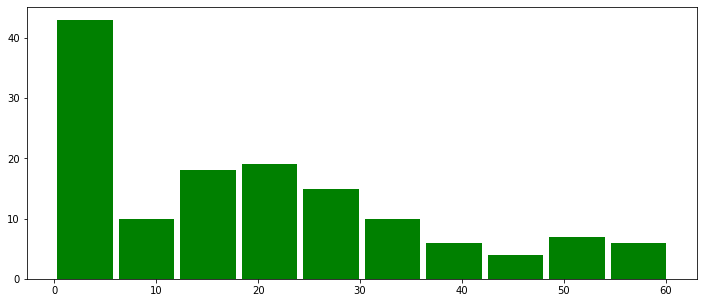

In [32]:
plt.figure(figsize=(12,5))
values = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)']
plt.hist(x=values, bins=10, color='Green', rwidth=0.9)

### TESTE

In [60]:
def display_gradcam(img_path, heatmap, alpha=1, pred=None):

    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    if pred == 'malignant':
        jet = cm.get_cmap("jet")
    else:
        jet = cm.get_cmap("Greens")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
     


    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap) 
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = np.array(jet_heatmap) 

    superimposed_img = (jet_heatmap * alpha) + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    
    plt.imshow(superimposed_img)

    jet_heatmap = cv.cvtColor(jet_heatmap, cv.COLOR_BGR2GRAY)

    _, thresh = cv.threshold(jet_heatmap,0,255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    return thresh

In [61]:
df[df['Interpret. Region Accuracy (%)'] == df['Interpret. Region Accuracy (%)'].max()]

,Case,Total Tumor Cells,Pred. Type,Probability (%),Tumors Found,Interpret. Region Accuracy (%)
22,Case_11-13,63,malignant,99.8,38,60.32


In [62]:
case='Case_11-09'

In [63]:
IMG = 'BreCaHAD_test/dataset/malignant/'+case+'.png'
PATH1 = 'BreCaHAD_test/groundTruth_display/'+case+'.png'

1/1 [==============================] - 0s 41ms/step


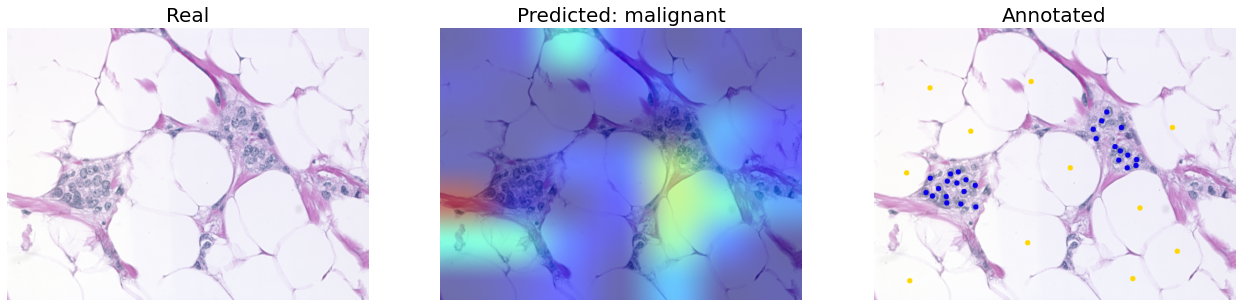

In [64]:

img = tf.keras.utils.load_img(PATH1)
img_orig = tf.keras.utils.load_img(IMG)
heatmap1, class_1, probs1 = generate_heatmap(IMG)

plt.figure(figsize=(22,22))
plt.subplot(1,3,1)
plt.title('Real',fontsize=20)
plt.axis(False)
plt.imshow(img_orig)
plt.subplot(1,3,2)
plt.title(f'Predicted: {class_1}', fontsize=20)
plt.axis(False)
result=display_gradcam(img_path=IMG, heatmap=heatmap1, pred=class_1)
plt.subplot(1,3,3)
plt.title('Annotated', fontsize=20)
plt.axis(False)
plt.imshow(img)

In [69]:
'''plt.figure(figsize=(10,10))

plt.imshow(result, cmap='gray')'''

"plt.figure(figsize=(10,10))\n\nplt.imshow(result, cmap='gray')"

In [70]:
'''# inverting result mask
plt.figure(figsize=(20,20))
data1 = cv.imread(PATH1)
data1 = cv.cvtColor(data1, cv.COLOR_BGR2RGB)
final = cv.bitwise_and(data1, data1, mask = result)
final = cv.cvtColor(final, cv.COLOR_RGB2GRAY)
plt.subplot(1,2,1)
plt.imshow(final, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(data1)'''

"# inverting result mask\nplt.figure(figsize=(20,20))\ndata1 = cv.imread(PATH1)\ndata1 = cv.cvtColor(data1, cv.COLOR_BGR2RGB)\nfinal = cv.bitwise_and(data1, data1, mask = result)\nfinal = cv.cvtColor(final, cv.COLOR_RGB2GRAY)\nplt.subplot(1,2,1)\nplt.imshow(final, cmap='gray')\nplt.subplot(1, 2, 2)\nplt.imshow(data1)"

In [71]:
'''plt.figure(figsize=(10,10))

kernel = np.ones((5,5),np.uint8)
mask2 = cv.threshold(final,0,255,cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
mask2 = cv.morphologyEx(mask2, cv.MORPH_CLOSE, kernel)
mask2 = np.uint8(mask2)
plt.imshow(mask2, cmap='gray')'''

"plt.figure(figsize=(10,10))\n\nkernel = np.ones((5,5),np.uint8)\nmask2 = cv.threshold(final,0,255,cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]\nmask2 = cv.morphologyEx(mask2, cv.MORPH_CLOSE, kernel)\nmask2 = np.uint8(mask2)\nplt.imshow(mask2, cmap='gray')"